In [2]:
# import tf packages
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [4]:
# read stock data and preview
stock = pd.read_csv("https://raw.githubusercontent.com/Yyao5/tf_LSTMstockprice/main/PFE.csv")
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-05,33.548386,33.709679,33.415562,33.624287,27.812943,28665006
1,2016-08-08,33.472485,33.472485,32.931690,33.140415,27.412703,32189687
2,2016-08-09,33.197342,33.491463,33.111954,33.282730,27.530424,18054388
3,2016-08-10,33.368122,33.377609,33.121441,33.330170,27.569666,14887328
4,2016-08-11,33.330170,33.472485,33.301708,33.349148,27.585365,14106841


In [6]:
# calculate returns in the stock table
stock['PrevClose'] = stock['Close'].shift(1)
stock['Return'] = (stock['Close']-stock['PrevClose'])/stock['PrevClose']
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,PrevClose,Return
0,2016-08-05,33.548386,33.709679,33.415562,33.624287,27.812943,28665006,NaN,NaN
1,2016-08-08,33.472485,33.472485,32.931690,33.140415,27.412703,32189687,33.624287,-0.014391
2,2016-08-09,33.197342,33.491463,33.111954,33.282730,27.530424,18054388,33.140415,0.004294
3,2016-08-10,33.368122,33.377609,33.121441,33.330170,27.569666,14887328,33.282730,0.001425
4,2016-08-11,33.330170,33.472485,33.301708,33.349148,27.585365,14106841,33.330170,0.000569


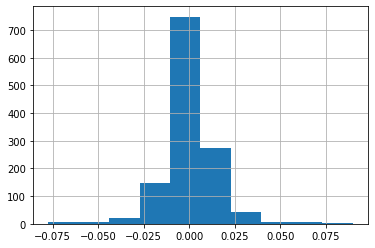

In [7]:
# Visualize returns and then normalize it
stock['Return'].hist()

In [10]:
# The normalization only used first half of the data and then flatten it
series = stock['Return'].values[1:].reshape(-1,1)
scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten()

In [11]:
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1247, 10, 1) Y.shape (1247,)


In [12]:
# Autoregressive RNN
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

/Users/yyt/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/80
20/20 [==============================] - 2s 26ms/step - loss: 1.0252 - val_loss: 2.3808
Epoch 2/80
20/20 [==============================] - 0s 7ms/step - loss: 1.0081 - val_loss: 2.3809
Epoch 3/80
20/20 [==============================] - 0s 6ms/step - loss: 1.0016 - val_loss: 2.3887
Epoch 4/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9991 - val_loss: 2.3986
Epoch 5/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9916 - val_loss: 2.4145
Epoch 6/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9858 - val_loss: 2.4241
Epoch 7/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9831 - val_loss: 2.4347
Epoch 8/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9742 - val_loss: 2.4368
Epoch 9/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9677 - val_loss: 2.4433
Epoch 10/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9651 - val_loss: 2.4596
Epoch 11/80
20/20 

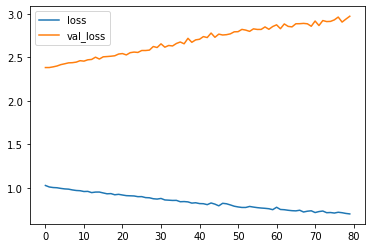

In [13]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1247, 1)


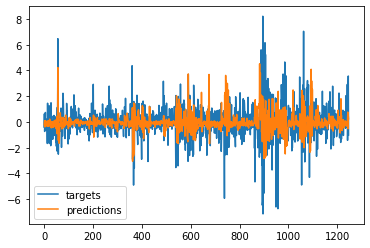

In [14]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

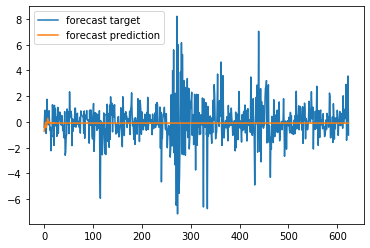

In [15]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [17]:
# Make Y as booleen
input_data = stock[['Open', 'High', 'Low', 'Close', 'Volume']].values
targets = stock['Return'].values
T = 10
D = input_data.shape[1]
N = len(input_data)-T


In [18]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [19]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [20]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [21]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

/Users/yyt/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [22]:
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 3s 40ms/step - loss: 0.7001 - accuracy: 0.4809 - val_loss: 0.6943 - val_accuracy: 0.5146
Epoch 2/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6935 - accuracy: 0.4988 - val_loss: 0.6936 - val_accuracy: 0.4951
Epoch 3/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6918 - accuracy: 0.5084 - val_loss: 0.6934 - val_accuracy: 0.4927
Epoch 4/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6911 - accuracy: 0.5334 - val_loss: 0.6948 - val_accuracy: 0.4878
Epoch 5/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6905 - accuracy: 0.5310 - val_loss: 0.6952 - val_accuracy: 0.4902
Epoch 6/300
27/27 [==============================] - 0s 15ms/step - loss: 0.6917 - accuracy: 0.5286 - val_loss: 0.6948 - val_accuracy: 0.4976
Epoch 7/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6887 - accuracy: 0.5382 - val_loss: 0.6954 - val_accuracy: 0.5049
Epoch 8/30

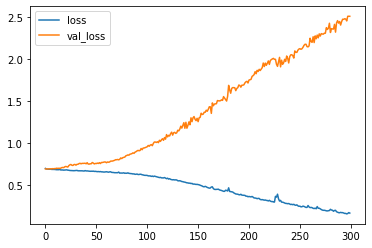

In [23]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

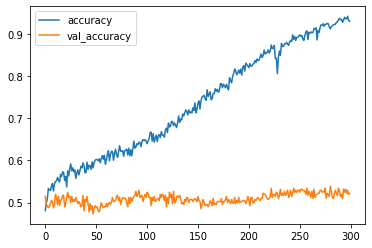

In [24]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()